In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./hn_survey_26k.csv")
df.head()

,rowid,id,age,occup,gender,origlat,origlon,destlat,destlon,purp,...,alt_taxi,alt_walk,opinion_car,opinion_motob,opinion_ebike,opinion_bike,opinion_taxi,opinion_bus,opinion_ban,index
0,1,81355306,56_75,retired,female,21.017745,105.789006,20.991929,105.805990,visit,...,0,0,bad,bad,good,good,bad,bad,agree,1
1,2,84299385,18_25,student,male,21.042960,105.805248,21.046880,105.785251,education,...,0,0,neutral,neutral,neutral,neutral,neutral,neutral,disagree,1
2,3,84733115,18_25,student,female,20.989184,105.795480,20.989289,105.795570,education,...,0,0,verygood,good,good,good,good,good,disagree,1
3,4,81532595,18_25,student,male,21.006678,105.825425,21.006742,105.825081,education,...,0,0,bad,bad,neutral,neutral,neutral,neutral,disagree,1
4,5,84300298,18_25,private,female,21.031790,105.801981,21.034103,105.795577,work,...,0,0,neutral,neutral,neutral,neutral,neutral,neutral,neutral,1


In [3]:
# 2. Tiền xử lý dữ liệu
# Chọn biến quan tâm


selected_cols = ['freqpweek','freq_car', 'dist_to_pub',
                 'own_car', 'own_motob', 'own_bike', 'own_ebike', 'aware_ban',
                 'vehic', 'fut_veh', 'opinion_ban']
df_model = df[selected_cols].copy()
df_model.head()

,freqpweek,freq_car,dist_to_pub,own_car,own_motob,own_bike,own_ebike,aware_ban,vehic,fut_veh,opinion_ban
0,1_3,1_5,400,1,0,1,0,no,taxi,no,agree
1,4_7,NaN,500,0,4,0,0,donotcare,moto,car,disagree
2,8_10,NaN,50,1,3,0,1,yes,moto,car,disagree
3,17_20,NaN,100,0,3,0,0,no,walk,car,disagree
4,4_7,NaN,500,0,2,0,0,yes,moto,car,neutral


In [4]:
#Xử lý missing values
df_model = df_model.dropna(subset=['opinion_ban'])

#Chuyển dữ liệu sang numeric
df_model = df_model.replace(['more_5'],7)
df_model.own_car = pd.to_numeric(df_model.own_car)
df_model.own_motob = pd.to_numeric(df_model.own_motob)
df_model.own_bike = pd.to_numeric(df_model.own_bike)
df_model.own_ebike = pd.to_numeric(df_model.own_ebike)

#Xóa dữ liệu neutral
df_model = df_model[df_model['opinion_ban'] != 'neutral']


In [5]:
#Mã hóa biến phụ thuộc
mapping = {'strongdisagree': 0, 'disagree': 0, 'agree': 1, 'strongagree': 1}
df_model['opinion_ban_code'] = df_model['opinion_ban'].map(mapping)
df_model.head()

,freqpweek,freq_car,dist_to_pub,own_car,own_motob,own_bike,own_ebike,aware_ban,vehic,fut_veh,opinion_ban,opinion_ban_code
0,1_3,1_5,400,1,0,1,0,no,taxi,no,agree,1
1,4_7,NaN,500,0,4,0,0,donotcare,moto,car,disagree,0
2,8_10,NaN,50,1,3,0,1,yes,moto,car,disagree,0
3,17_20,NaN,100,0,3,0,0,no,walk,car,disagree,0
5,4_7,NaN,50,2,2,0,1,no,moto,car,agree,1


In [6]:
#Mã hóa biến độc lập
#Xử lý biến tần suất
freq_mapping = {
    '1_5': 3,
    '6_10': 8,
    '11_15': 13,
    '16_20': 18,
    'more_20': 25
}

freqpweek_mapping = {
    '1_3': 2,
    '4_7': 5.5,
    '8_10': 9,
    '11_13': 12,
    '14_16': 15,
    '17_20': 18.5,
    'more_20': 25
}

#Mã hóa freq_car
df_model['freq_car'] = df_model['freq_car'].map(freq_mapping).fillna(0)
#Mã hóa freqpweek
df_model['freqpweek'] = df_model['freqpweek'].map(freqpweek_mapping).fillna(0)

#One-hot coding
df_model = pd.get_dummies(df_model, columns=['aware_ban', 'vehic', 'fut_veh'], dtype=int, drop_first=True)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19807 entries, 0 to 26104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freqpweek         19807 non-null  float64
 1   freq_car          19807 non-null  float64
 2   dist_to_pub       19807 non-null  int64  
 3   own_car           19807 non-null  int64  
 4   own_motob         19807 non-null  int64  
 5   own_bike          19807 non-null  int64  
 6   own_ebike         19807 non-null  int64  
 7   opinion_ban       19807 non-null  object 
 8   opinion_ban_code  19807 non-null  int64  
 9   aware_ban_no      19807 non-null  int32  
 10  aware_ban_yes     19807 non-null  int32  
 11  vehic_bus         19807 non-null  int32  
 12  vehic_car         19807 non-null  int32  
 13  vehic_ebike       19807 non-null  int32  
 14  vehic_moto        19807 non-null  int32  
 15  vehic_taxi        19807 non-null  int32  
 16  vehic_tram        19807 non-null  int32  
 17

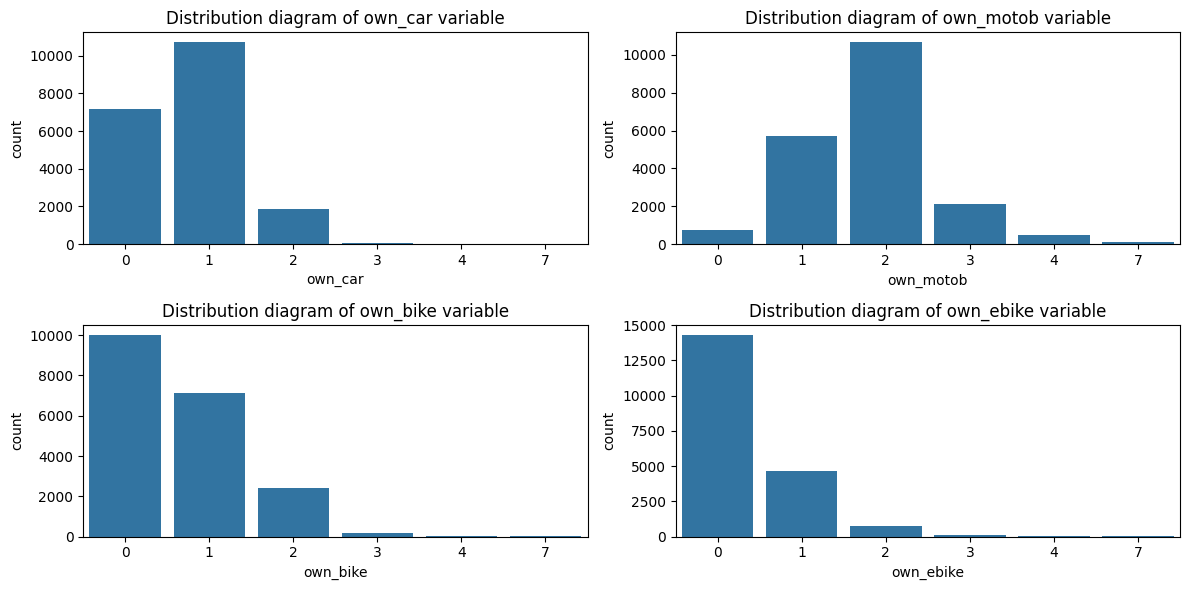

In [7]:
cat_vars = ['own_car', 'own_motob', 'own_bike', 'own_ebike']

plt.figure(figsize=(12, 6))
for i, var in enumerate(cat_vars):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=var, data=df_model, width=0.85)
    plt.title(f'Distribution diagram of {var} variable')

plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import pointbiserialr

cat_vars = ['own_car', 'own_motob', 'own_bike', 'own_ebike']

for var in cat_vars: 
    corr, p_value = pointbiserialr(df_model['opinion_ban_code'], df_model[var])
    print(f"Correlation of opinion_ban and {var}: {corr:.4f}, P-value: {p_value:.4f}")

Correlation of opinion_ban and own_car: 0.3539, P-value: 0.0000
Correlation of opinion_ban and own_motob: -0.0233, P-value: 0.0010
Correlation of opinion_ban and own_bike: 0.1625, P-value: 0.0000
Correlation of opinion_ban and own_ebike: -0.0460, P-value: 0.0000


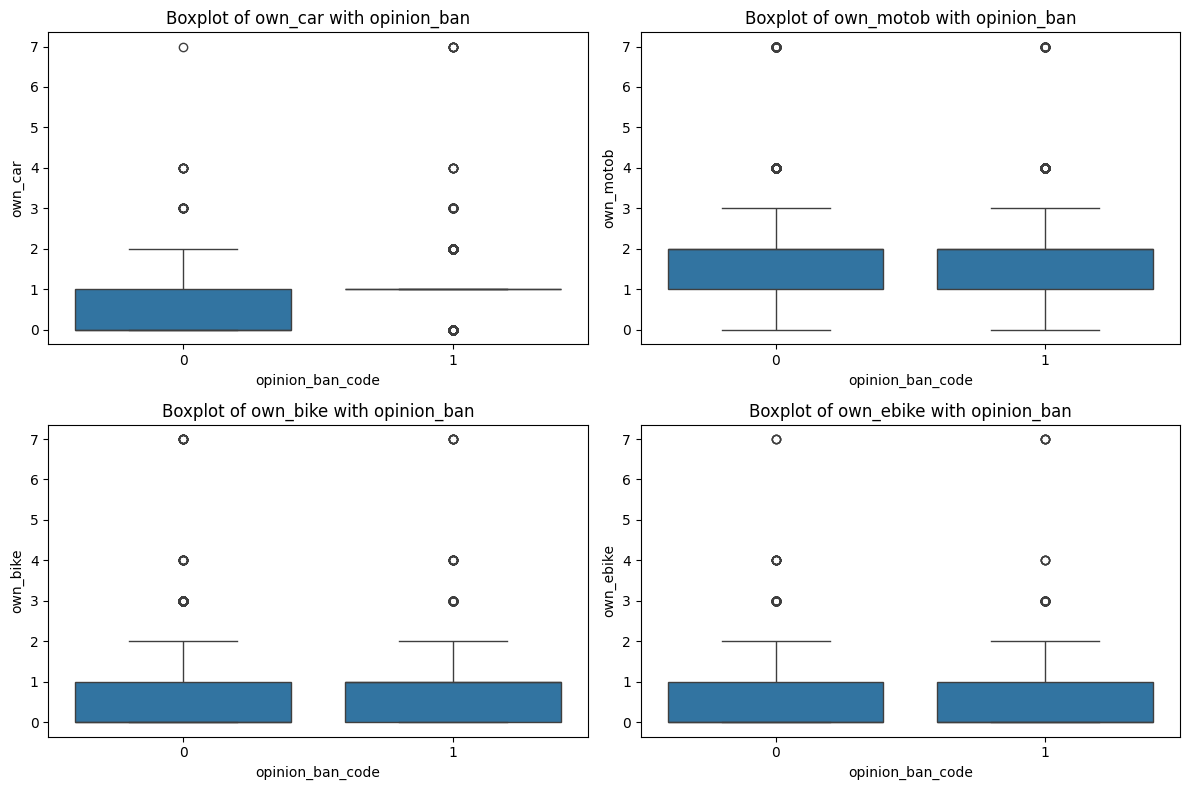


Summary Statistics for 'own_car' grouped by opinion_ban:

  Group opinion_ban_code = 0:
    Mean: 0.45
    Median: 0.00
    Mode: 0
    Std Dev: 0.57
    Skewness: 1.25
    Kurtosis: 3.88

  Group opinion_ban_code = 1:
    Mean: 0.92
    Median: 1.00
    Mode: 1
    Std Dev: 0.63
    Skewness: 0.74
    Kurtosis: 5.57

Summary Statistics for 'own_motob' grouped by opinion_ban:

  Group opinion_ban_code = 0:
    Mean: 1.84
    Median: 2.00
    Mode: 2
    Std Dev: 1.04
    Skewness: 1.33
    Kurtosis: 4.65

  Group opinion_ban_code = 1:
    Mean: 1.80
    Median: 2.00
    Mode: 2
    Std Dev: 0.74
    Skewness: 1.01
    Kurtosis: 7.82

Summary Statistics for 'own_bike' grouped by opinion_ban:

  Group opinion_ban_code = 0:
    Mean: 0.49
    Median: 0.00
    Mode: 0
    Std Dev: 0.75
    Skewness: 2.31
    Kurtosis: 10.17

  Group opinion_ban_code = 1:
    Mean: 0.74
    Median: 1.00
    Mode: 0
    Std Dev: 0.77
    Skewness: 0.88
    Kurtosis: 1.96

Summary Statistics for 'own_ebike' 

In [9]:
cat_vars = ['own_car', 'own_motob', 'own_bike', 'own_ebike']
target = 'opinion_ban_code'

plt.figure(figsize=(12, 8))

for i, var in enumerate(cat_vars):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=target, y=var, data=df_model)
    plt.title(f'Boxplot of {var} with opinion_ban')
    plt.xlabel('opinion_ban_code')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

from scipy.stats import skew, kurtosis

for var in cat_vars:
    print(f"\nSummary Statistics for '{var}' grouped by opinion_ban:")
    for val in sorted(df_model[target].unique()):
        group = df_model[df_model[target] == val][var]
        print(f"\n  Group {target} = {val}:")
        print(f"    Mean: {group.mean():.2f}")
        print(f"    Median: {group.median():.2f}")
        print(f"    Mode: {group.mode().iloc[0] if not group.mode().empty else 'N/A'}")
        print(f"    Std Dev: {group.std():.2f}")
        print(f"    Skewness: {skew(group):.2f}")
        print(f"    Kurtosis: {kurtosis(group):.2f}")


In [10]:
from scipy.stats import mannwhitneyu

for var in ['own_car', 'own_motob', 'own_bike', 'own_ebike']:
    group0 = df_model[df_model['opinion_ban_code'] == 0][var]
    group1 = df_model[df_model['opinion_ban_code'] == 1][var]
    
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    print(f'{var}: Mann-Whitney U statistic = {stat:.2f}, p-value = {p:.4f}')

own_car: Mann-Whitney U statistic = 27808386.50, p-value = 0.0000
own_motob: Mann-Whitney U statistic = 45317956.00, p-value = 0.0231
own_bike: Mann-Whitney U statistic = 36787340.00, p-value = 0.0000
own_ebike: Mann-Whitney U statistic = 47664040.00, p-value = 0.0000


In [11]:
# 3. Chuẩn bị biến độc lập và phụ thuộc
y = df_model['opinion_ban_code']
X = df_model.drop(['opinion_ban', 'opinion_ban_code','vehic_moto'], axis=1)


In [12]:
## Kiểm định Đa Cộng Tuyến
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                  for i in range(X.shape[1])]
print(vif_data.sort_values("VIF", ascending=False))

         Variable       VIF
4       own_motob  5.545251
8   aware_ban_yes  4.531540
15    fut_veh_car  4.495232
18     fut_veh_no  4.238174
0       freqpweek  3.871590
3         own_car  3.392117
17   fut_veh_moto  2.998435
7    aware_ban_no  2.002574
5        own_bike  1.945073
10      vehic_car  1.899306
1        freq_car  1.817398
6       own_ebike  1.531974
16  fut_veh_ebike  1.518470
11    vehic_ebike  1.143094
14     vehic_walk  1.056352
9       vehic_bus  1.045781
12     vehic_taxi  1.038351
2     dist_to_pub  1.013664
13     vehic_tram  1.002676


In [23]:
from statsmodels.discrete.discrete_model import Logit

model_logit = Logit(y,X)

result_logit = model_logit.fit(method="newton")

print(result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.465044
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       opinion_ban_code   No. Observations:                19807
Model:                          Logit   Df Residuals:                    19788
Method:                           MLE   Df Model:                           18
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.2987
Time:                        22:37:12   Log-Likelihood:                -9211.1
converged:                       True   LL-Null:                       -13134.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
freqpweek        -0.0556      0.005    -12.176      0.000      -0.065      -0.047
freq_car          0.

In [14]:
print(result_logit.get_margeff(at='overall').summary())

        Logit Marginal Effects       
Dep. Variable:       opinion_ban_code
Method:                          dydx
At:                           overall
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
freqpweek        -0.0086      0.001    -12.362      0.000      -0.010      -0.007
freq_car          0.0457      0.001     44.280      0.000       0.044       0.048
dist_to_pub   -7.134e-06   3.71e-06     -1.924      0.054   -1.44e-05    1.35e-07
own_car           0.1108      0.005     20.777      0.000       0.100       0.121
own_motob        -0.0245      0.003     -7.580      0.000      -0.031      -0.018
own_bike          0.0536      0.004     13.289      0.000       0.046       0.061
own_ebike        -0.0549      0.005    -10.603      0.000      -0.065      -0.045
aware_ban_no      0.1067      0.010     11.011      0.000       0.088       0.126
aware_ban_yes     0.2768    

In [15]:
coef = result_logit.params
odds_ratio = np.exp(coef)
percent_change = (odds_ratio - 1) * 100  # đổi sang %

# Tạo bảng tóm tắt
summary_df = pd.DataFrame({
    'Variable': coef.index,
    'Coef': coef.values,
    'Odds_Ratio': odds_ratio,
    'Percent_Change (%)': percent_change
})

# Lấy top 10 biến theo độ lớn ảnh hưởng
top10 = summary_df.reindex(percent_change.abs().sort_values(ascending=False).index).head(10)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_9236\4089075518.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


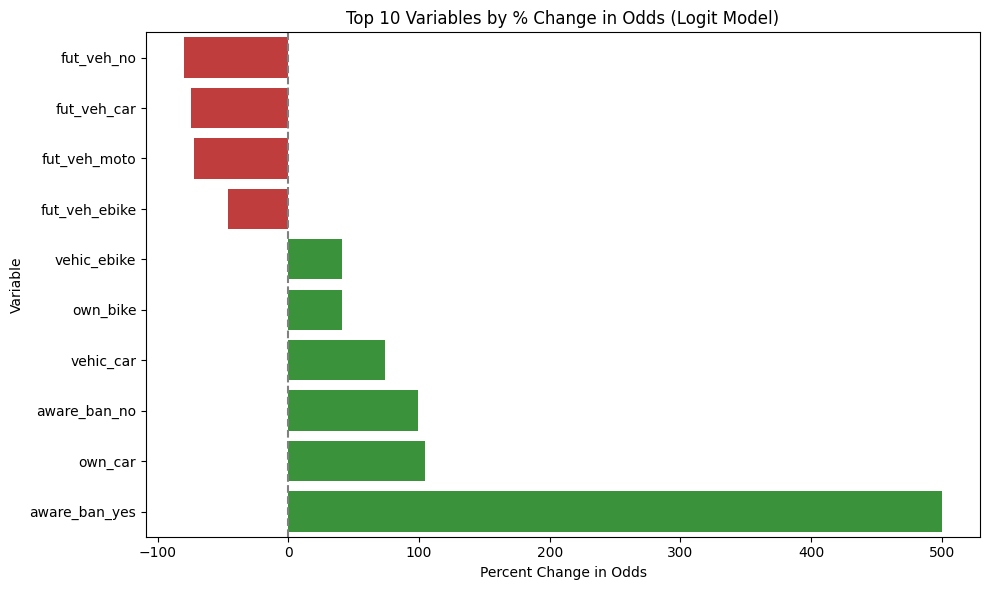

In [16]:
top10_sorted = top10.sort_values(by='Percent_Change (%)')

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_sorted,
    x='Percent_Change (%)',
    y='Variable',
    palette=['#d62728' if x < 0 else '#2ca02c' for x in top10_sorted['Percent_Change (%)']]
)

plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Top 10 Variables by % Change in Odds (Logit Model)')
plt.xlabel('Percent Change in Odds')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [18]:
df_model.to_csv('preprocessing_data.csv', index=False)